Instructions for running: Just restart the kernel with running all cells and the outputs will be as intended

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors as cl
from sklearn import neighbors as nb
import copy

In [2]:
iris_data = pd.read_csv("iris.data", names=["sepal length", "sepal width", "petal length", "petal width", "class"])
iris_data # Note all lengths & widths are in cm

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


# Clustering

### a)

In [3]:
def run_k_means(K):
    clusters = [] # list of dataframes with all elements in cluster
    initial_clusters = []
    intermediate_clusters = []
    initial_means = []
    intermediate_means = []
    means = [] # list of dictionaries with means of all elements in cluster
    sampled = [] # list of indices from dataset that are clustered in initial sampling
    # Initial clusters
    i = 0
    while i < K:
        s = iris_data.sample()
        if s.index in sampled: # Don't let same data point be sampled more than once
            continue
        clusters.append(s)
        means.append(np.array([s.iloc[0,0], s.iloc[0,1], s.iloc[0,2], s.iloc[0,3]]))
        sampled.append(s.index)
        i += 1
    # Assign other data to clusters
    distortions = []
    for i in range(25): # Assume converged after 25 iterations
        D = 0
        for n in range(len(iris_data)):
            new_data = np.array([iris_data.iloc[n,0], iris_data.iloc[n,1], iris_data.iloc[n,2], iris_data.iloc[n,3]])
            min_distance = np.linalg.norm(means[0] - new_data)
            min_cluster = 0
            for k in range(1, K):
                temp_distance = np.linalg.norm(means[k] - new_data)
                if temp_distance < min_distance:
                    min_distance = temp_distance
                    min_cluster = k
            clusters[min_cluster].loc[len(clusters[min_cluster].index)] = iris_data.iloc[n]
            D += np.linalg.norm(means[min_cluster] - new_data) ** 2
        # Update mu_k
        if i == 0: # Initial
            initial_clusters = copy.deepcopy(clusters)
            initial_means = copy.deepcopy(means)
        elif i == 2: # Intermediate
            intermediate_clusters = copy.deepcopy(clusters)
            intermediate_means = copy.deepcopy(means)
        if i != 24:
            for k in range(K):
                means[k][0] = clusters[k]["sepal length"].mean()
                means[k][1] = clusters[k]["sepal width"].mean()
                means[k][2] = clusters[k]["petal length"].mean()
                means[k][3] = clusters[k]["petal width"].mean()
                clusters[k].drop(clusters[k].index, inplace=True) # Clear clusters to prepare for next iteration
        distortions.append(D)
    return (distortions, clusters, means, initial_clusters, initial_means, intermediate_clusters, intermediate_means)

In [4]:
result = run_k_means(3)

### b)

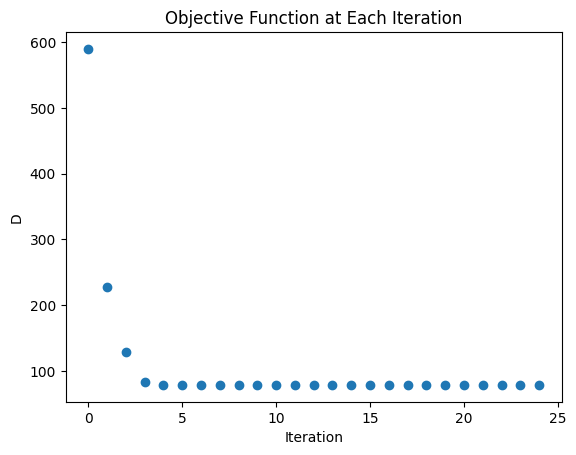

In [5]:
distortions = result[0]
plt.scatter(range(len(distortions)), distortions)
plt.xlabel('Iteration')
plt.ylabel('D')
plt.title('Objective Function at Each Iteration')
plt.show()

### c)
Note that the means are represented by the darker points in each cluster color

In [6]:
def plotClusters(clusters, means, title):
    colors = ['salmon', 'lightblue', 'lightgreen']
    mean_colors = ['red', 'dodgerblue', 'forestgreen']
    for i in range(len(clusters)):
        plt.scatter(clusters[i]['petal length'], clusters[i]['petal width'], c=colors[i])
        plt.scatter(means[i][2], means[i][3], c=mean_colors[i])
    
    plt.xlabel('Petal Length (cm)')
    plt.ylabel('Petal Width (cm)')
    plt.title(title)
    plt.show()

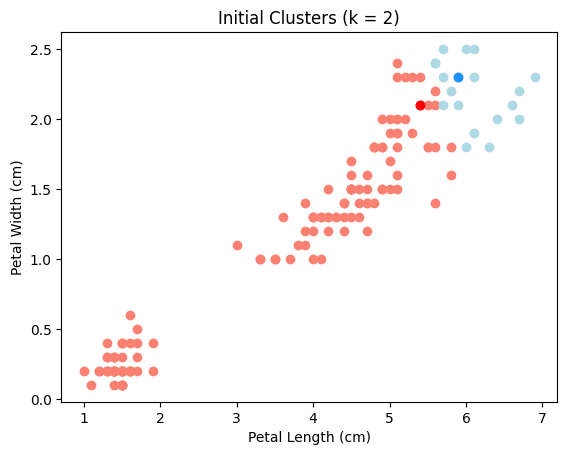

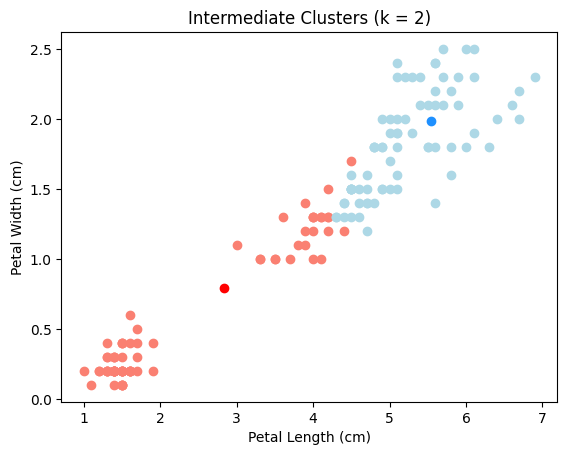

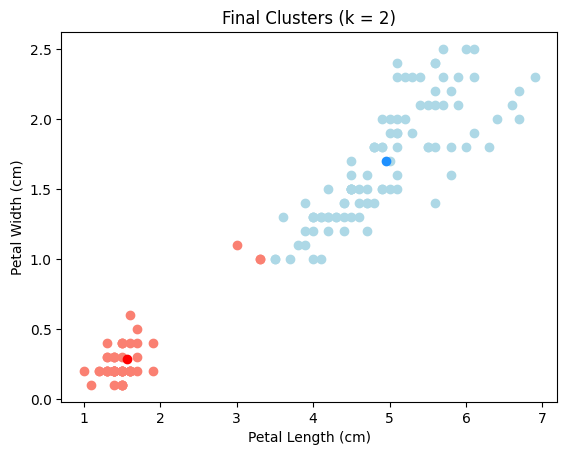

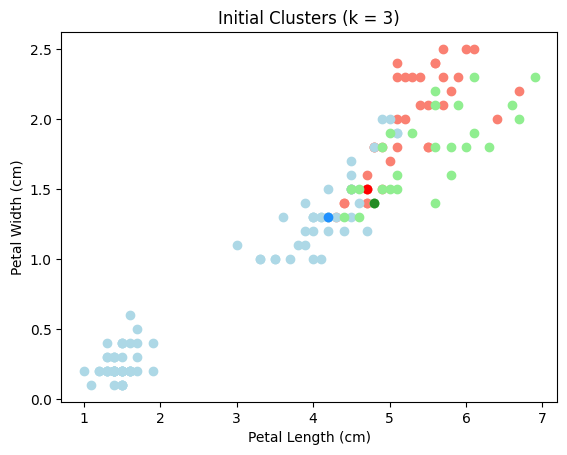

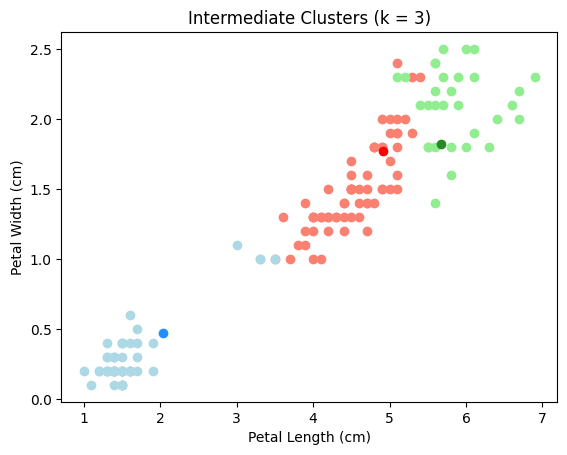

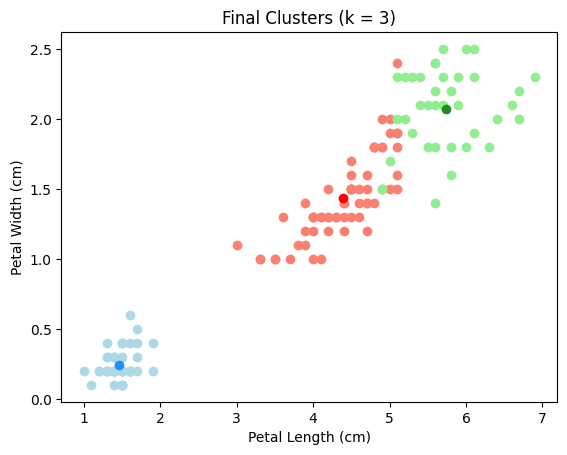

In [7]:
result2 = run_k_means(2)
plotClusters(result2[3], result2[4], 'Initial Clusters (k = 2)')
plotClusters(result2[5], result2[6], 'Intermediate Clusters (k = 2)')
plotClusters(result2[1], result2[2], 'Final Clusters (k = 2)')
plotClusters(result[3], result[4], 'Initial Clusters (k = 3)')
plotClusters(result[5], result[6], 'Intermediate Clusters (k = 3)')
plotClusters(result[1], result[2], 'Final Clusters (k = 3)')

### d)
I used Python libraries (matplotlib, sklearn) to plot colored regions representing the different clusters of data corresponding to the types of flowers. It is with respect to the variables of petal length and petal width. I made it a callable method so that it could be replicated for different values of k.

In [8]:
def decision_boundary(k):
    values = iris_data[["sepal length", "sepal width", "petal length", "petal width"]].to_numpy(copy=True)
    classes = iris_data[["class"]].to_numpy(copy=True)
    types = []
    for i in range(len(classes)):
        if classes[i][0] not in types:
            types.append(classes[i][0])
        classes[i][0] = types.index(classes[i][0])
    classes = classes.astype(int)
    colors = ['red', 'dodgerblue', 'forestgreen']
    color_map = cl.ListedColormap(colors[:k])
    near_centroid = nb.NearestCentroid()
    classification = near_centroid.fit(values, classes)
    # Petal length bounds
    x_lower = values[:, 2].min() - 1
    x_upper = values[:, 2].max() + 1
    # Petal width bounds
    y_lower = values[:, 3].min() - 1
    y_upper = values[:, 3].max() + 1
    # Organize data to prepare for graphing
    mean_l = np.mean(values[:, 0])
    mean_w = np.mean(values[:, 1])
    a, b = np.meshgrid(np.arange(x_lower, x_upper, 0.05), np.arange(y_lower, y_upper, 0.05))
    a_array = a.ravel()
    b_array = b.ravel()
    mean_l = [mean_l for i in range(len(a_array))]
    mean_w = [mean_w for i in range(len(b_array))]
    prediction = classification.predict(np.array([mean_l, mean_w, a_array, b_array]).T)
    prediction = prediction.reshape(a.shape)
    # Plot
    plt.contourf(a, b, prediction, alpha=0.4, cmap=color_map)
    plt.xlim(a.min(), a.max())
    plt.ylim(b.min(), b.max())
    plt.title('Decision Boundaries (k = ' + str(k) + ')')
    plt.xlabel('Petal Length')
    plt.ylabel('Petal Width')
    plt.show()

C:\Users\emile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


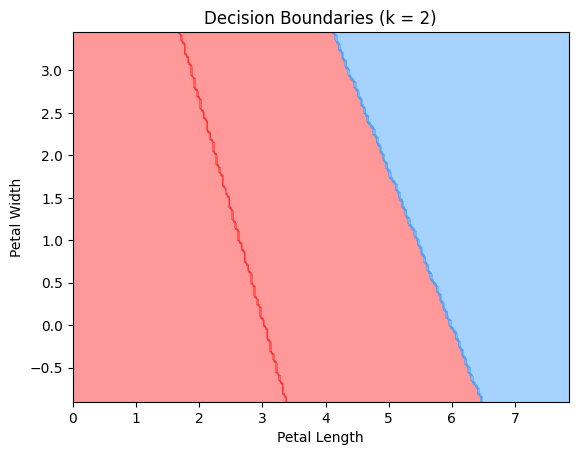

C:\Users\emile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


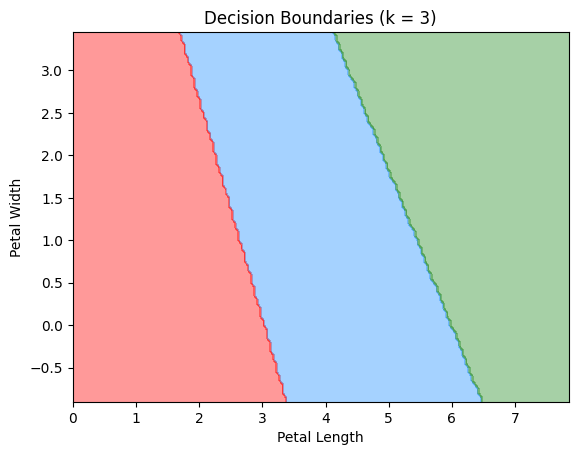

In [9]:
decision_boundary(2)
decision_boundary(3)

# Neural Networks

### a)

In [37]:
def mean_squared_error(data, weights, bias, y):
    y_hat = np.dot(data, weights) + bias
    predicteds = 1.0 / (1 + np.exp(-1 * y_hat)) # Sigmoid function
    predicted_class = []
    for i in range(len(predicteds)):
        # if preds >= 0.5, round up to 1 (otherwise round down to 0)
        if(predicteds[i] > 0.5):
            predicted_class.append(1)
        else:
            predicted_class.append(0)
    y_hat = np.array(predicted_class)
    # Calculate MSE using y-hat
    mse = 0
    for i in range(len(y_hat)):
        mse += (y_hat[i] - y[i])**2
    mse /= len(y)
    return mse

### b)

In [38]:
def network_decision_boundary(df, data, weights, bias, title):
    b = -1 * (bias / weights[1])
    m = -1 * (weights[0] / weights[1])
    x = np.array([2.5,7]) # x-range for line
    y = m * x + b
    plt.scatter(df['petal length'], df['petal width'])
    plt.plot(x, y)
    plt.xlabel('Petal Length (cm)')
    plt.ylabel('Petal Width (cm)')
    plt.title(title)
    plt.show()

Small MSE: 0.06


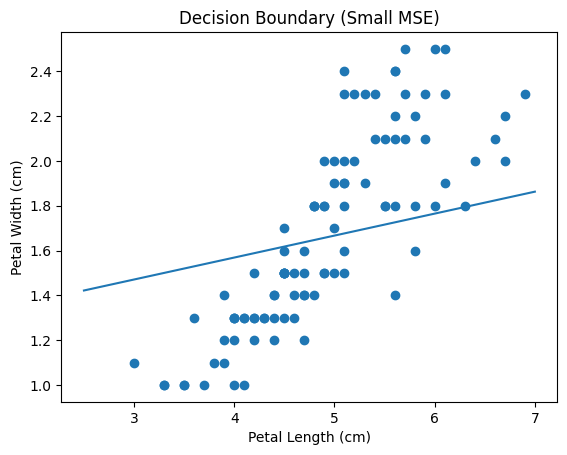

Large MSE: 0.5


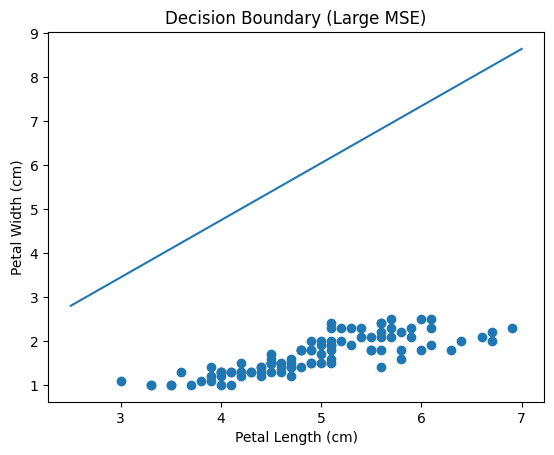

In [39]:
# Only look at data that is of class 2 or 3 (not class 1)
partial_iris = iris_data.copy()
partial_iris = partial_iris[partial_iris['class'] != 'Iris-setosa']
values = partial_iris.iloc[:,2:4]
actual = partial_iris.iloc[:,4]
values = values.to_numpy()
actual = actual.to_numpy()
for i in range (len(actual)):
    if(actual[i] == "Iris-versicolor"):
        actual[i] = 0
    else: # Virginica
        actual[i] = 1
actual = actual.astype(int)
# Small MSE
small_weights = np.array([-0.05, 0.51])
small_bias = -0.6
print("Small MSE:", mean_squared_error(values, small_weights, small_bias, actual))
network_decision_boundary(partial_iris, values, small_weights, small_bias, "Decision Boundary (Small MSE)")
# Large MSE
large_weights = np.array([55.2, -42.5])
large_bias = -19
print("Large MSE:", mean_squared_error(values, large_weights, large_bias, actual))
network_decision_boundary(partial_iris, values, large_weights, large_bias, "Decision Boundary (Large MSE)")

### e)

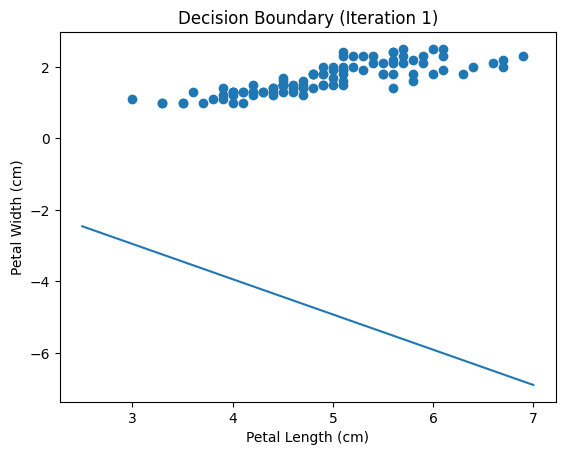

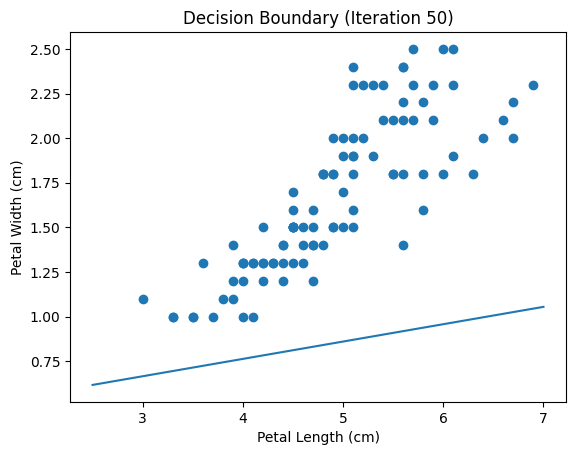

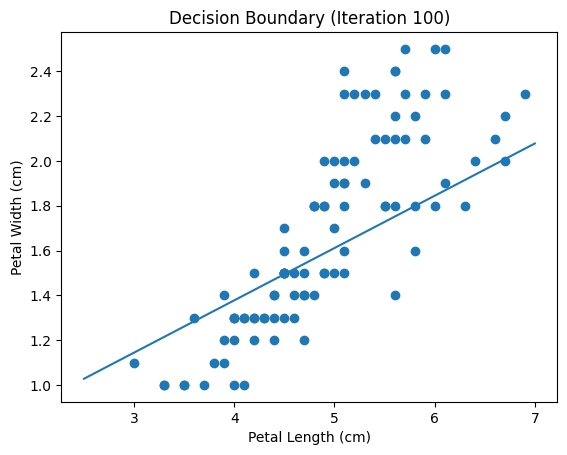

In [48]:
weights = [1.0, 1.0] # Start at default 1 to see descent
bias = 0 # Leave bias as 0 for simplicity

for i in range(101):
    y_hat = np.dot(values, weights) + bias
    predicteds = 1.0 / (1 + np.exp(-1 * y_hat)) # Sigmoid function
    predicted_class = []
    for j in range(len(predicteds)):
        # if preds >= 0.5, round up to 1 (otherwise round down to 0)
        if(predicteds[j] > 0.5):
            predicted_class.append(1)
        else:
            predicted_class.append(0)
    y_hat = np.array(predicted_class)
    if i == 1:
        network_decision_boundary(partial_iris, y_hat, weights, bias, "Decision Boundary (Iteration 1)")
    elif i == 50:
        network_decision_boundary(partial_iris, y_hat, weights, bias, "Decision Boundary (Iteration 50)")
    elif i == 100:
        network_decision_boundary(partial_iris, y_hat, weights, bias, "Decision Boundary (Iteration 100)")

    w_gradient = []
    b_gradient = 0
    for j in range(len(values)): 
        b_gradient += y_hat[j] - actual[j]
    
    # Update gradients
    for k in range(len(weights)):
        gradient_sum = 0
        for j in range(len(values)):
            gradient_sum += (y_hat[j] - actual[j]) * values[j][k]
        w_gradient.append(gradient_sum)
    w_gradient = np.array(w_gradient)
    weights -= 0.0001*w_gradient
    bias -= 0.0001*b_gradient